### Full DnW Conversion ###

Converting both temperature to demand and wind speed to wind power generation, then taking the difference to calculate demand net wind. All in the same notebook.

Wind speed -> Wind power generation conversion first

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import (
    plot_distributions_fidelity,
    plot_cdfs,
    plot_qq,
    plot_rp_extremes,
    estimate_period,
    sigmoid,
    apply_detrend,
)

In [3]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Load the model data
df_model_sfcWind = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv"
)

# set up the df obs sfcwing
df_obs_sfcWind = pd.read_csv(
    "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_United_Kingdom_1960-2018_daily_2024-12-11.csv"
)

# load the clearheads data for wind generation
df_ch = pd.read_csv(
    "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv"
)

In [4]:
# Clean the obs data
df_obs_sfcWind["time"] = pd.to_datetime(
    df_obs_sfcWind["time"], origin="1952-01-01", unit="D"
)

# subset the data to O, N, D, J, F, M
df_obs_sfcWind = df_obs_sfcWind[
    df_obs_sfcWind["time"].dt.month.isin([10, 11, 12, 1, 2, 3])
]

In [5]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

In [6]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [7]:
df_obs_sfcWind.tail()

,time,data
21545,2018-12-27,2.477261
21546,2018-12-28,3.448565
21547,2018-12-29,5.573635
21548,2018-12-30,4.381348
21549,2018-12-31,5.464558


In [8]:
df_model_sfcWind.head()

,init_year,member,lead,data
0,1960,1,1,8.429288
1,1960,1,2,9.267500
2,1960,1,3,7.539931
3,1960,1,4,7.504783
4,1960,1,5,5.574239


In [9]:
# # Plot the distribution of 10m wind speed
# plot_distributions_fidelity(
#     obs_df=df_obs_sfcWind,
#     model_df=df_model_ondjfm,
#     obs_val_name="data",
#     model_val_name="data",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK 10m Wind Speed (GW)",
#     nboot=10,
#     figsize=(12, 6),
#     fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now fit the sigmoid

In [10]:
# Set up an initial guess for the parameters based on the observed data
p0 = [
    max(df_ch["wind_gen"]),
    np.median(df_obs_sfcWind["data"]),
    1,
    min(df_ch["wind_gen"]),
]

# Fit the sigmoid curve to the data
popt, pcov = curve_fit(
    sigmoid, df_obs_sfcWind["data"], df_ch["wind_gen"], p0=p0, method="dogbox"
)

Density range: 0.0 to 0.056535721756982675
Contour interval: 0.01884524058566089


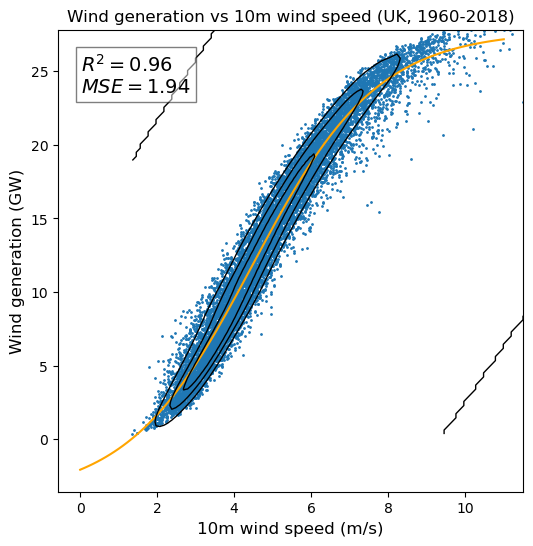

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error


# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b


# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind["data"], df_ch["wind_gen"], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind["data"])), 100)
ax.plot(
    x,
    sigmoid(x, *popt),
    "r-",
    label="fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f" % tuple(popt),
    color="orange",
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind["data"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind["data"].min(), df_obs_sfcWind["data"].max()
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], sigmoid(df_obs_sfcWind["data"], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], sigmoid(df_obs_sfcWind["data"], *popt))

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("10m wind speed (m/s)", fontsize=12)
ax.set_ylabel("Wind generation (GW)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Fit looks good. Now we want to evaluate the performance of the converted model wind generation in terms of statistics.

In [12]:
# First create a column in the obs using the sigmoid function
df_obs_sfcWind["wind_gen_sigmoid"] = sigmoid(df_obs_sfcWind["data"], *popt)

Density range: 0.0 to 0.013703024744784043
Contour interval: 0.004567674914928014


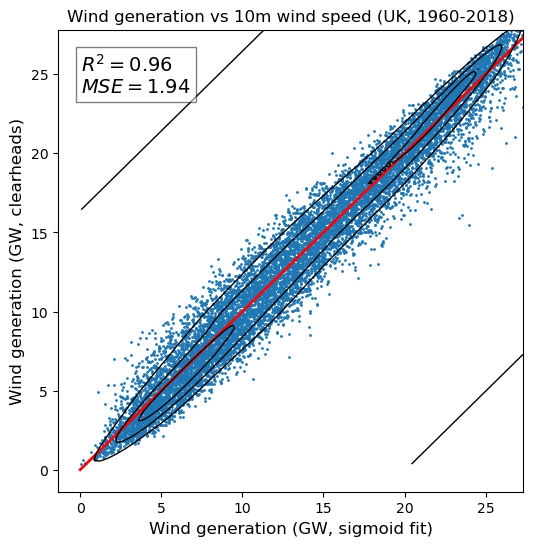

In [13]:
# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"], s=1)

# plot the 1:1 line as a solid black line
ax.plot(
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    color="red",
    linestyle="-",
    linewidth=2,
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = (
    df_obs_sfcWind["wind_gen_sigmoid"].min(),
    df_obs_sfcWind["wind_gen_sigmoid"].max(),
)
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("Wind generation (GW, sigmoid fit)", fontsize=12)
ax.set_ylabel("Wind generation (GW, clearheads)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Sigmoid fit does a pretty good job of replicating the clearheads wind generation, albeit with +- 2/3 GW of uncertainty.

Now apply the same sigmoid fit to the model 10m wind speed data.

In [14]:
df_model_ondjfm_sfcWind = df_model_ondjfm.copy()

In [15]:
df_model_ondjfm_sfcWind["wind_gen_sigmoid"] = sigmoid(
    df_model_ondjfm_sfcWind["data"], *popt
)

In [16]:
# # Compare the wind generation distribution from the model and the obs
# plot_distributions_fidelity(
#     obs_df=df_ch,
#     model_df=df_model_ondjfm,
#     obs_val_name="wind_gen", # CLEARHEADS ground-truth
#     model_val_name="wind_gen_sigmoid", # 10m wind speed sigmoid fit
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK Wind Generation (GW)",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_wind_generation_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Temperature -> demand ###

Do the conversion from temperature to demand.

In [17]:
# load the model data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

# add a new column for temp c in the model data
df_model_ondjfm_wyear["data_c"] = df_model_ondjfm_wyear["data"] - 273.15

# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = (
    df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]
)

# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([10, 11, 12, 1, 2, 3])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [18]:
%%time

# Apply the detrend function to the data
df_obs_tas, df_model_tas = apply_detrend(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="lead",
)

The mean slope is 0.030071677811841058
The 2.5th percentile of the slopes is -0.013596000239910108
The 97.5th percentile of the slopes is 0.07067023285905695
The slope of the observations is 0.029431150102115586
The trend line obs is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend line model is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend final is 6.040066916249145
The trend final obs is 5.739350138130732
The model_val_name is data_c
The obs_val_name is data_c
The mean of the model data is 6.0440047854461305
The mean of the obs data is 6.083428703753268
CPU times: user 34.7 s, sys: 6.63 ms, total: 34.7 s
Wall time: 34.9 s


In [19]:
# # Validate the detrended temperature
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="data_c_dt",
#     model_val_name="data_c_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK temperature (C) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_temp_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now convert to demand through HDD, CDD, and the regression relationships.

In [20]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas["hdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, hdd_base - x))
df_obs_tas["cdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas["hdd_dt"] = df_model_tas["data_c_dt"].apply(lambda x: max(0, hdd_base - x))
df_model_tas["cdd_dt"] = df_model_tas["data_c_dt"].apply(lambda x: max(0, x - cdd_base))

In [21]:
# Set up the path to the regression coeffs
regr_coeffs = (
    "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"
)

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand detrended
df_obs_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_obs_tas["hdd_dt"])
    + (cdd_coeff_uk * df_obs_tas["cdd_dt"])
)

# Calculate the model demand detrended
df_model_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_model_tas["hdd_dt"])
    + (cdd_coeff_uk * df_model_tas["cdd_dt"])
)

In [22]:
# # Now validate the UK demand against the observed data
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="UK_demand_dt",
#     model_val_name="UK_demand_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK demand (GW) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_demand_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Demand net wind ###

Now merge the dataframes to look at the demand net wind.

In [23]:
# merge the obs data
df_obs = df_obs_sfcWind.merge(df_obs_tas, on="time", how="inner")

In [24]:
# rename data_x as "10m_wind_speed" and data_y as "temp_K"
df_obs.rename(columns={"data_x": "10m_wind_speed", "data_y": "temp_K"}, inplace=True)

In [25]:
df_model_ondjfm_sfcWind.head()

,init_year,member,lead,data,wind_gen_sigmoid
330,1960,1,331,4.469876,11.806168
331,1960,1,332,5.489894,16.641298
332,1960,1,333,6.172364,19.457478
333,1960,1,334,4.134217,10.172521
334,1960,1,335,4.603901,12.460984


In [26]:
df_model_ondjfm_sfcWind.rename(columns={"data": "10m_wind_speed"}, inplace=True)
df_model_tas.rename(columns={"data": "temp_K"}, inplace=True)

In [27]:
# Merge the model data on "init_year", "lead", and "member"
df_model = df_model_ondjfm_sfcWind.merge(
    df_model_tas, on=["init_year", "lead", "member"], how="inner"
)

In [28]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [29]:
# Calculate the demand_dt_net_wind
df_model["demand_dt_net_wind"] = df_model["UK_demand_dt"] - df_model["wind_gen_sigmoid"]

In [30]:
# Calculate the demand_dt_net_wind for the obs
df_obs["demand_dt_net_wind"] = df_obs["UK_demand_dt"] - df_ch["wind_gen"]

In [31]:
# # Compare the demand_dt_net_wind distribution from the model and the obs
# plot_distributions_fidelity(
#     obs_df=df_obs,
#     model_df=df_model,
#     obs_val_name="demand_dt_net_wind",  # Empirical demand - CH wind generation
#     model_val_name="demand_dt_net_wind",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK demand - wind generation (GW) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_demand_net_wind_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Looks pretty good! No bias correction needed either!!

Now do the conversion into the number of exceedance days for the winter to look at the overall severity.

In [32]:
# If time is a column for obs df
df_obs["time"] = pd.to_datetime(df_obs["time"])

# Set time as the index
df_obs.set_index("time", inplace=True)

In [33]:
df_obs.columns

Index(['10m_wind_speed', 'wind_gen_sigmoid', 'temp_K', 'data_c', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

In [34]:
df_ch.columns

Index(['date', 'solar_power', '100m_wind_speed', '10m_wind_speed',
       'solar_irradiance', 'ofs_cfs', 'ons_cfs', 't2m_no_detrend',
       't2m_2020_detrend', 'United_Kingdom_demand', 'United_Kingdom_wd_demand',
       'wind_gen', 'demand_net_wind', 'wd_demand_net_wind'],
      dtype='object')

In [35]:
df_ch["date"] = pd.to_datetime(df_ch["date"])

df_ch.set_index("date", inplace=True)

Plot the histograms of wind generation. To decide the obs threshold to use for wind drought days.

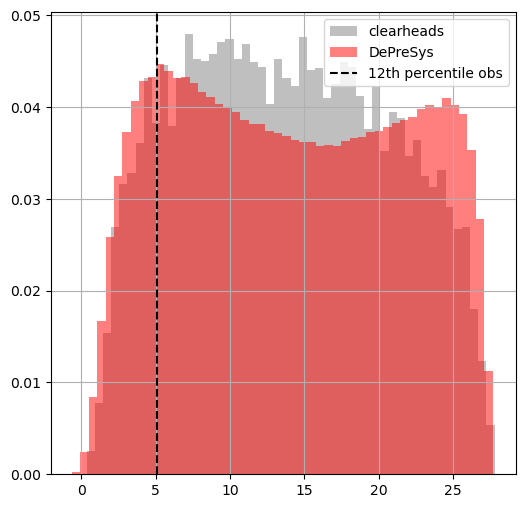

In [36]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the wind generation clearheads
df_ch["wind_gen"].hist(
    bins=50, ax=ax, alpha=0.5, label="clearheads", color="gray", density=True
)

# Plot a histogram of the wind generation obs
df_model["wind_gen_sigmoid"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_ch["wind_gen"].quantile(0.12),
    color="black",
    linestyle="--",
    label="12th percentile obs",
)

# include a legend
ax.legend()

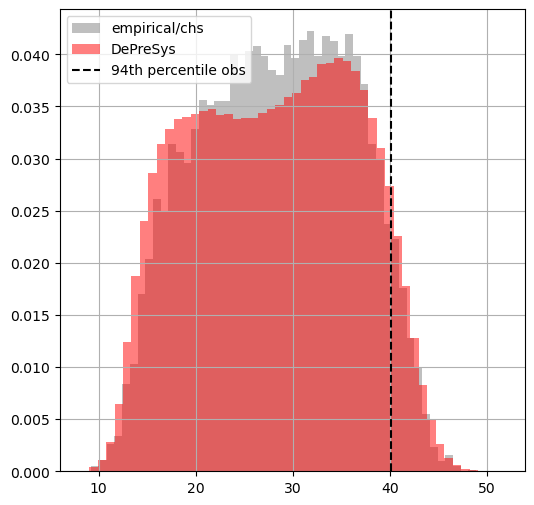

In [37]:
# Plot the distribution of the detrended demand - wind generation
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical/chs", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["demand_dt_net_wind"].quantile(0.94),
    color="black",
    linestyle="--",
    label="94th percentile obs",
)

# include a legend in the top left
ax.legend(loc="upper left")

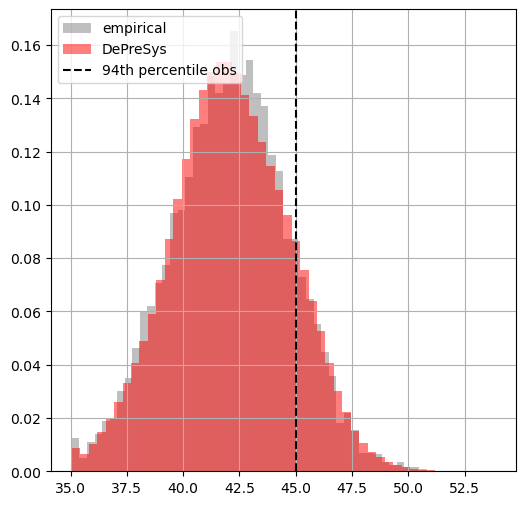

In [38]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["UK_demand_dt"].quantile(0.87),
    color="black",
    linestyle="--",
    label="94th percentile obs",
)

# include a legend in the top left
ax.legend(loc="upper left")

12th percentile of wind generation considered as ~5 GW of generation, which is very low/unusual during the winter. Can always test and adjust.

94th percentile of detrended demand net wind ~ 40 GW identified by Ben Sloman at NESO.

87th percentile of detrended demand ~ 45 GW which is high.

In [62]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
no_exceedance_days_demand = []
severity_index_demand = []

# Same for wind speed
no_undershoot_days_wind = []
severity_index_wind = []

# # Same for demand net wind
no_exceedance_days_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
# 87th percentile for demand ~ 45 GW
all_winters_high_demand = np.percentile(df_obs["UK_demand_dt"], 87)

# 94th percentile for demand net wind ~ 40 GW identified by Ben Sloman as being
# challenging
all_winters_high_DnW = np.percentile(df_obs["demand_dt_net_wind"], 94)

# 12th percentile of wind generation ~ 5 GW
# Which is pretty low during the winter
all_winters_low_wind = np.percentile(df_ch["wind_gen"], 12)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs.loc[winter_start:winter_end]
    df_ch_this = df_ch.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask_demand = df["UK_demand_dt"] > all_winters_high_demand
    mask_DnW = df["demand_dt_net_wind"] > all_winters_high_DnW
    mask_wind = df_ch_this["wind_gen"] < all_winters_low_wind

    # calculate the severity index
    severity_index_demand_this = (
        df["UK_demand_dt"][mask_demand] - all_winters_high_demand
    ).sum()
    severity_index_demand_net_wind_this = (
        df["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
    ).sum()
    severity_index_wind_this = (
        all_winters_low_wind - df_ch_this["wind_gen"][mask_wind]
    ).sum()

    # append these to the list
    severity_index_demand.append(severity_index_demand_this)
    severity_index_demand_net_wind.append(severity_index_demand_net_wind_this)
    severity_index_wind.append(severity_index_wind_this)

    # calculate the no. exceedance days
    no_exceedance_days_demand_this = mask_demand.sum()
    no_exceedance_days_demand_net_wind_this = mask_DnW.sum()
    no_undershoot_days_wind_this = mask_wind.sum()

    # append these to the list
    no_exceedance_days_demand.append(no_exceedance_days_demand_this)
    no_exceedance_days_demand_net_wind.append(no_exceedance_days_demand_net_wind_this)
    no_undershoot_days_wind.append(no_undershoot_days_wind_this)

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity_index_demand": severity_index_demand,
        "no_exceedance_days_demand": no_exceedance_days_demand,
        "severity_index_demand_net_wind": severity_index_demand_net_wind,
        "no_exceedance_days_demand_net_wind": no_exceedance_days_demand_net_wind,
        "severity_index_wind": severity_index_wind,
        "no_undershoot_days_wind": no_undershoot_days_wind,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [40]:
df_model.columns

Index(['init_year', 'member', 'lead', '10m_wind_speed', 'wind_gen_sigmoid',
       'temp_K', 'winter_year', 'data_c', 'effective_dec_year', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

No pre-bias correction of the model data necessary in this case.

In [41]:
# Extract the unique init years
init_years = df_model["init_year"].unique()
members = df_model["member"].unique()
winter_years = df_model["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for demand net wind
model_severity_index_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for wind generation
model_severity_index_wind = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_undershoot_days_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model[
                (df_model["init_year"] == i_year)
                & (df_model["member"] == member)
                & (df_model["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask_demand = df_this["UK_demand_dt"] > all_winters_high_demand
            mask_DnW = df_this["demand_dt_net_wind"] > all_winters_high_DnW
            mask_wind = df_this["wind_gen_sigmoid"] < all_winters_low_wind

            # calculate the severity index
            model_severity_index_demand[i, j, k] = (
                df_this["UK_demand_dt"][mask_demand] - all_winters_high_demand
            ).sum()
            model_severity_index_demand_net_wind[i, j, k] = (
                df_this["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
            ).sum()
            model_severity_index_wind[i, j, k] = (
                all_winters_low_wind - df_this["wind_gen_sigmoid"][mask_wind]
            ).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days_demand[i, j, k] = mask_demand.sum()
            model_no_exceedance_days_demand_net_wind[i, j, k] = mask_DnW.sum()
            model_no_undershoot_days_wind[i, j, k] = mask_wind.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity_index_demand": [model_severity_index_demand[i, j, k]],
                    "no_exceedance_days_demand": [
                        model_no_exceedance_days_demand[i, j, k]
                    ],
                    "severity_index_demand_net_wind": [
                        model_severity_index_demand_net_wind[i, j, k]
                    ],
                    "no_exceedance_days_demand_net_wind": [
                        model_no_exceedance_days_demand_net_wind[i, j, k]
                    ],
                    "severity_index_wind": [model_severity_index_wind[i, j, k]],
                    "no_undershoot_days_wind": [model_no_undershoot_days_wind[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [42]:
# Create the effective_dec_year column
df_model_exceedance["effective_dec_year"] = (
    df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]
)

In [43]:
import importlib
importlib.reload(sys.modules["functions"])
from functions import dot_plot

In [44]:
df_exceedance_days_obs.head()

,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
1960,0.790387,2,8.833997,7,49.157260,27
1961,27.877418,24,26.456997,15,53.891523,31
1962,117.716482,67,67.184280,26,53.061683,32
1963,9.360300,12,8.456894,8,38.369448,31
1964,22.499508,22,9.901393,7,44.089426,28


Bad events have high values
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_net_wind_model-no_exceedance_days_demand_net_wind_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-33.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_net_wind_model-no_exceedance_days_demand_net_wind_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-33.pdf


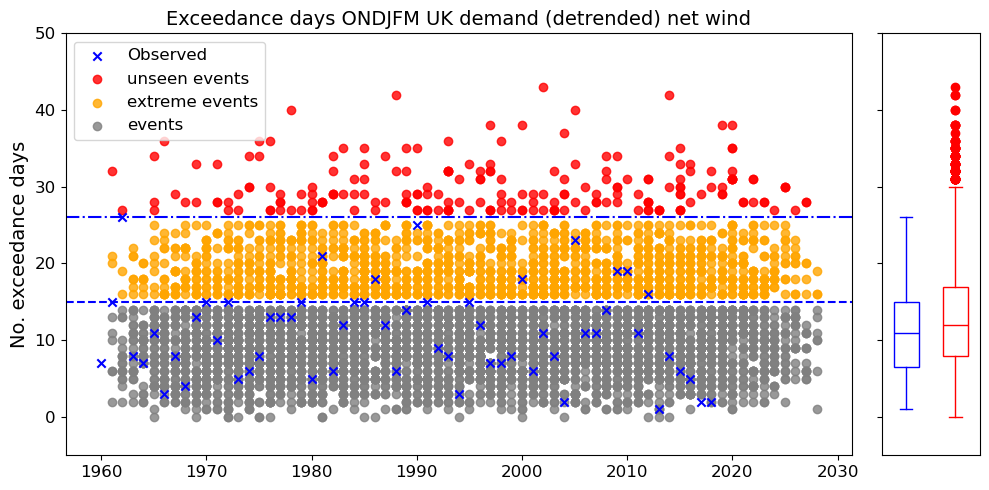

In [45]:
# plot the demand net wind exceedance days
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    model_time_name="effective_dec_year",
    ylabel="No. exceedance days",
    title="Exceedance days ONDJFM UK demand (detrended) net wind",
    ylims=(-5, 50),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Bad events have high values


Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-34.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-34.pdf


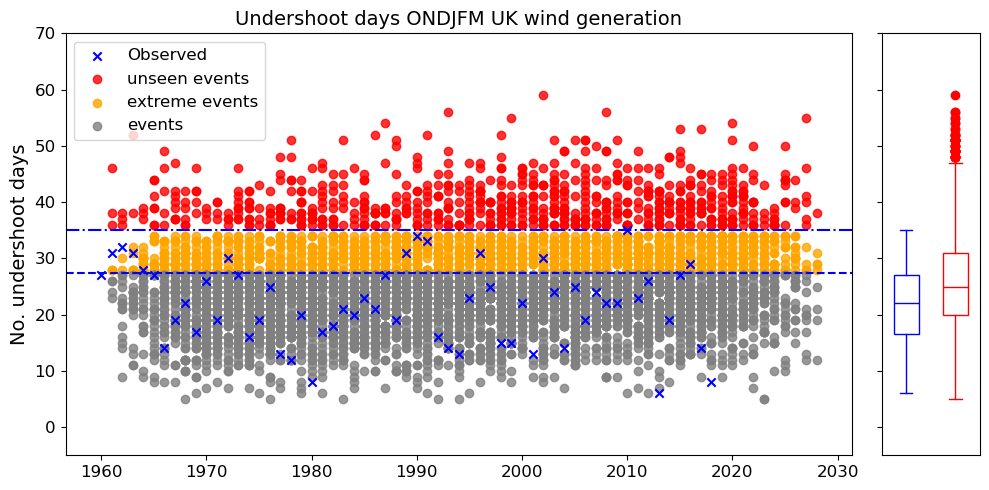

In [46]:
# Do the same but for wind power
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    model_time_name="effective_dec_year",
    ylabel="No. undershoot days",
    title="Undershoot days ONDJFM UK wind generation",
    ylims=(-5, 70),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Bad events have high values
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_model-no_exceedance_days_demand_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-35.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_model-no_exceedance_days_demand_quantile-0.8_solid-max_dot_plot_2024-12-16-14-46-35.pdf


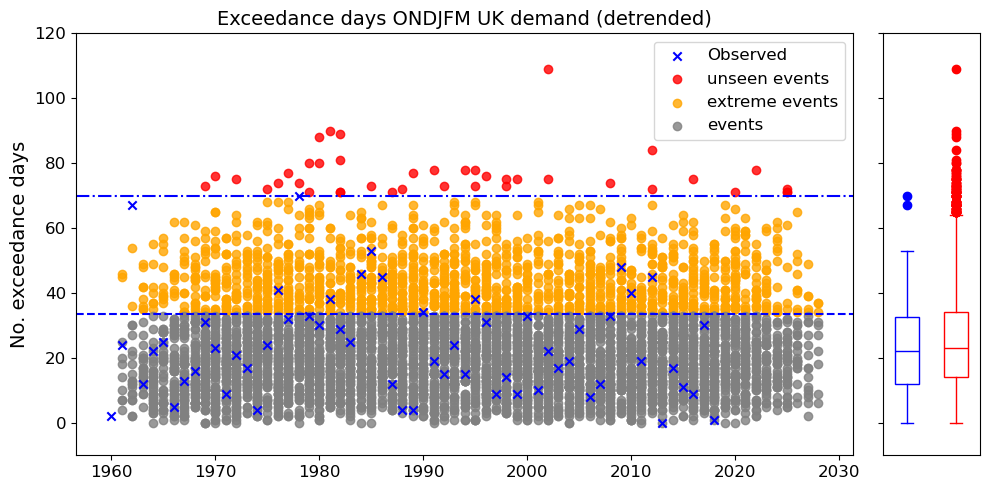

In [47]:
# Do the same but for detrended demand
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand",
    model_val_name="no_exceedance_days_demand",
    model_time_name="effective_dec_year",
    ylabel="No. exceedance days",
    title="Exceedance days ONDJFM UK demand (detrended)",
    ylims=(-10, 120),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now look at the return period for extremes.

In [48]:
# reset index of obs_df
df_exceedance_days_obs.reset_index(inplace=True)

In [49]:
df_exceedance_days_obs.head()

,index,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
0,1960,0.790387,2,8.833997,7,49.157260,27
1,1961,27.877418,24,26.456997,15,53.891523,31
2,1962,117.716482,67,67.184280,26,53.061683,32
3,1963,9.360300,12,8.456894,8,38.369448,31
4,1964,22.499508,22,9.901393,7,44.089426,28


In [50]:
# quantify the 99.9th percentile of the obs data for demand net wind
df_exceedance_days_obs["no_exceedance_days_demand_net_wind"].quantile(0.999)

np.float64(25.942000000000007)

In [51]:
np.max(df_exceedance_days_obs["no_exceedance_days_demand_net_wind"])

np.int64(26)

99.9th %tile ~ max(DnW exceedance days) ~ 26 days (1962/63 winter)

In [52]:
# # For demand net wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand_net_wind",
#     model_val_name="no_exceedance_days_demand_net_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 50),
#     percentile=99.9,
# )

In [53]:
# print the 99.9th percentile of the model data
print(np.max(df_model_exceedance["no_undershoot_days_wind"]))
print(np.quantile(df_model_exceedance["no_undershoot_days_wind"], 0.999))

59.0
54.0


In [54]:
# # Same for wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_undershoot_days_wind",
#     model_val_name="no_undershoot_days_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 70),
#     percentile=99.9,
# )

In [55]:
# # same for demand
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand",
#     model_val_name="no_exceedance_days_demand",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 120),
#     percentile=99.9,
# )

In [79]:
importlib.reload(sys.modules["functions"])
from functions import plot_rp_extremes_decades

In [63]:
df_exceedance_days_obs.head()

,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
1960,0.790387,2,8.833997,7,49.157260,27
1961,27.877418,24,26.456997,15,53.891523,31
1962,117.716482,67,67.184280,26,53.061683,32
1963,9.360300,12,8.456894,8,38.369448,31
1964,22.499508,22,9.901393,7,44.089426,28


In [58]:
# set up the index column as the index
df_exceedance_days_obs.set_index("index", inplace=True)

In [80]:
params, years = plot_rp_extremes_decades(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
)

Index of obs: Index([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype='int64')
The year with the greatest no. exceedance days is:  1962
The value is:  26


7it [06:18, 54.13s/it]

Time taken for fitting GEVs: 378.94395446777344


In [86]:
obs_df=df_exceedance_days_obs
model_df=df_model_exceedance
obs_val_name="no_exceedance_days_demand_net_wind"
model_val_name="no_exceedance_days_demand_net_wind"
worst_or_perc_rp="worst"
percentile=99.9
decades = np.arange(1960, 2030, 10)
plot_rp_percentage=True
years_period = (1960, 2028)
save_prefix = "rp_extremes_decades"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
y_label = "No. exceedance days"

In [87]:
model_df_rl.head()

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%),mean_rp (years),025_rp (years),975_rp (years)
0,1960,97.563685,97.385157,97.606338,0.024363,0.026148,0.023937,41.045594,38.243208,41.776998
1,1970,96.778439,96.808536,96.747916,0.032216,0.031915,0.032521,31.040849,31.333581,30.749514
2,1980,96.056851,96.183657,95.839971,0.039431,0.038163,0.041600,25.360445,26.203094,24.038295
3,1990,95.606280,95.709450,95.415778,0.043937,0.042906,0.045842,22.759756,23.307034,21.813952
4,2000,95.977712,96.083514,95.924664,0.040223,0.039165,0.040753,24.861469,25.533090,24.537852


Calculating return period for worst (max) event


7it [00:00, 1158.10it/s]

Upper errors: 0    0.001785
1    0.000301
2    0.001268
3    0.001032
4    0.001058
5    0.001564
6    0.001486
dtype: float64
Lower errors: 0    0.000427
1    0.000305
2    0.002169
3    0.001905
4    0.000530
5    0.001528
6    0.002897
dtype: float64
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/rp_extremes_decades_2024-12-16-15-38-48.pdf


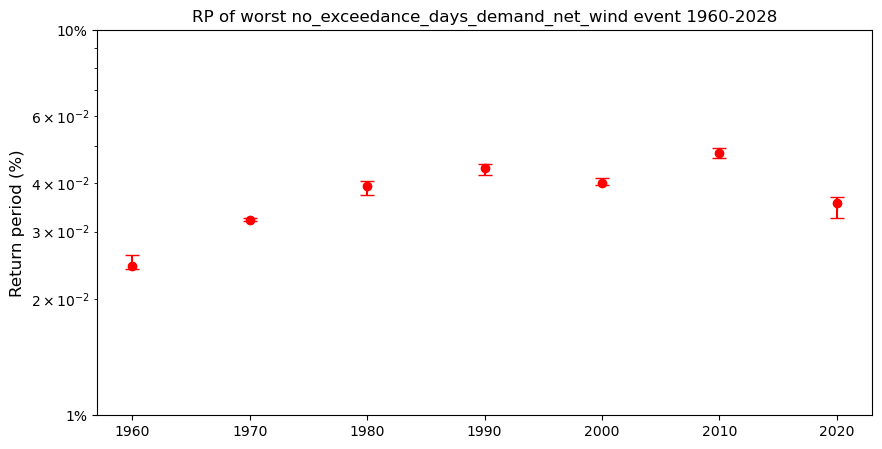

In [92]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(years)])
period_decade_025 = np.zeros([len(years)])
period_decade_975 = np.zeros([len(years)])

if worst_or_perc_rp == "worst":
    print("Calculating return period for worst (max) event")
    obs_bad_event = obs_df[obs_val_name].max()
elif worst_or_perc_rp == "perc":
    print(f"Calculating return period for {percentile}th percentile event")
    obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(years)):
    # Subset the params for the decade
    params_decade = params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# if we are plotting the return period as a percentage
if plot_rp_percentage:
    y_val_mean = model_df_rl["mean_rp (%)"]
    y_val_025 = model_df_rl["025_rp (%)"]
    y_val_975 = model_df_rl["975_rp (%)"]
    y_label = "Return period (%)"

    # Set up the error bars
    upper_errs = abs(model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
    lower_errs = abs(model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

    # set up the yticks
    yticks_ints = [0.01, 0.1]
    yticks_strs = ["1%", "10%"]

else:
    y_val_mean = model_df_rl["mean_rp (years)"]
    y_val_025 = model_df_rl["025_rp (years)"]
    y_val_975 = model_df_rl["975_rp (years)"]
    y_label = "Return period (years)"

    # Set up the error bars
    upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
    lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

    # set up the yticks
    yticks_ints = [1, 10, 100, 1000]
    yticks_strs = ["1", "10", "100", "1000"]

# print the upper and lower errors
print(f"Upper errors: {upper_errs}")
print(f"Lower errors: {lower_errs}")

# assert that upper errs and lower errors are positive
assert np.all(upper_errs > 0), "Upper errors must be positive"
assert np.all(lower_errs > 0), "Lower errors must be positive"

# Plot the mean
plt.scatter(
    model_df_rl["decade"],
    y_val_mean,
    color="red",
)

# Plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    y_val_mean,
    yerr=[lower_errs, upper_errs],
    fmt="none",
    color="red",
    capsize=5,
)

# Set up the yscale
plt.yscale("log")

# Set up the yticks
plt.yticks(yticks_ints, yticks_strs)

# Set up the ylabel
plt.ylabel(y_label, fontsize=12)

# Set up the title
if worst_or_perc_rp == "worst":
    plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
elif worst_or_perc_rp == "perc":
    plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# Set up the fname
fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# Set up the savepath
savepath = os.path.join(save_dir, fname)

# if the savepath does not exist
if not os.path.exists(savepath):
    print(f"Saving plot to {savepath}")

    # Save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)
else:
    print(f"Savepath {savepath} already exists")


In [93]:
df_exceedance_days_obs.columns

Index(['severity_index_demand', 'no_exceedance_days_demand',
       'severity_index_demand_net_wind', 'no_exceedance_days_demand_net_wind',
       'severity_index_wind', 'no_undershoot_days_wind'],
      dtype='object')

In [94]:
params, years = plot_rp_extremes_decades(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand",
    model_val_name="no_exceedance_days_demand",
    obs_time_name="index",
    model_time_name="effective_dec_year",
)

Index of obs: Index([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype='int64')
The year with the greatest no. exceedance days is:  1978
The value is:  70


7it [06:05, 52.25s/it]

Time taken for fitting GEVs: 365.76447653770447


In [95]:
obs_val_name="no_exceedance_days_demand"
model_val_name="no_exceedance_days_demand"

obs_df=df_exceedance_days_obs
model_df=df_model_exceedance
worst_or_perc_rp="worst"
percentile=99.9
decades = np.arange(1960, 2030, 10)
plot_rp_percentage=True
years_period = (1960, 2028)
save_prefix = "rp_extremes_decades"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
y_label = "No. exceedance days demand"

Calculating return period for worst (max) event


7it [00:00, 1176.24it/s]

Upper errors: 0    0.003084
1    0.001310
2    0.002023
3    0.001313
4    0.001872
5    0.001680
6    0.002800
dtype: float64
Lower errors: 0    0.002879
1    0.001396
2    0.002040
3    0.001809
4    0.001851
5    0.001467
6    0.002406
dtype: float64
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/rp_extremes_decades_2024-12-16-15-51-30.pdf


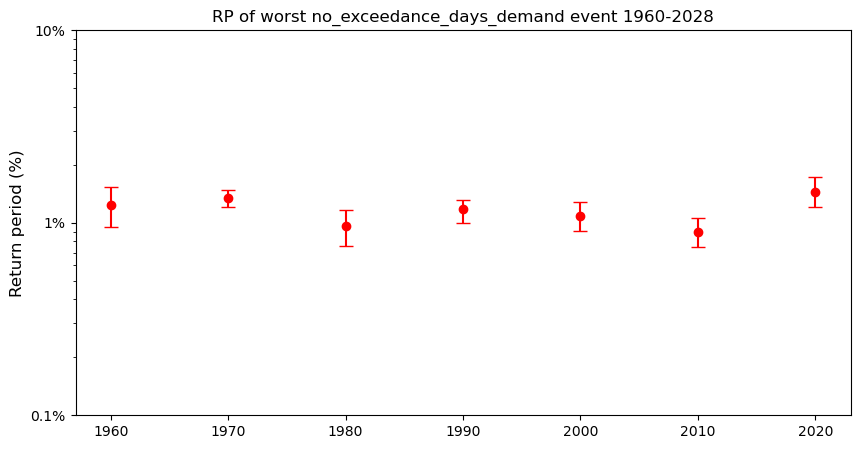

In [97]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(years)])
period_decade_025 = np.zeros([len(years)])
period_decade_975 = np.zeros([len(years)])

if worst_or_perc_rp == "worst":
    print("Calculating return period for worst (max) event")
    obs_bad_event = obs_df[obs_val_name].max()
elif worst_or_perc_rp == "perc":
    print(f"Calculating return period for {percentile}th percentile event")
    obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(years)):
    # Subset the params for the decade
    params_decade = params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# if we are plotting the return period as a percentage
if plot_rp_percentage:
    y_val_mean = model_df_rl["mean_rp (%)"]
    y_val_025 = model_df_rl["025_rp (%)"]
    y_val_975 = model_df_rl["975_rp (%)"]
    y_label = "Return period (%)"

    # Set up the error bars
    upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
    lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

    # set up the yticks
    yticks_ints = [0.001, 0.01, 0.1]
    yticks_strs = ["0.1%", "1%", "10%"]

else:
    y_val_mean = model_df_rl["mean_rp (years)"]
    y_val_025 = model_df_rl["025_rp (years)"]
    y_val_975 = model_df_rl["975_rp (years)"]
    y_label = "Return period (years)"

    # Set up the error bars
    upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
    lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

    # set up the yticks
    yticks_ints = [1, 10, 100, 1000]
    yticks_strs = ["1", "10", "100", "1000"]

# print the upper and lower errors
print(f"Upper errors: {upper_errs}")
print(f"Lower errors: {lower_errs}")

# assert that upper errs and lower errors are positive
assert np.all(upper_errs > 0), "Upper errors must be positive"
assert np.all(lower_errs > 0), "Lower errors must be positive"

# Plot the mean
plt.scatter(
    model_df_rl["decade"],
    y_val_mean,
    color="red",
)

# Plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    y_val_mean,
    yerr=[lower_errs, upper_errs],
    fmt="none",
    color="red",
    capsize=5,
)

# Set up the yscale
plt.yscale("log")

# Set up the yticks
plt.yticks(yticks_ints, yticks_strs)

# Set up the ylabel
plt.ylabel(y_label, fontsize=12)

# Set up the title
if worst_or_perc_rp == "worst":
    plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
elif worst_or_perc_rp == "perc":
    plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# Set up the fname
fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# Set up the savepath
savepath = os.path.join(save_dir, fname)

# if the savepath does not exist
if not os.path.exists(savepath):
    print(f"Saving plot to {savepath}")

    # Save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)
else:
    print(f"Savepath {savepath} already exists")

In [99]:
params, years = plot_rp_extremes_decades(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
)

Index of obs: Index([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype='int64')
The year with the greatest no. exceedance days is:  2010
The value is:  35


7it [06:11, 53.01s/it]

Time taken for fitting GEVs: 371.03953218460083


In [100]:
obs_val_name="no_undershoot_days_wind"
model_val_name="no_undershoot_days_wind"

obs_df=df_exceedance_days_obs
model_df=df_model_exceedance
worst_or_perc_rp="worst"
percentile=99.9
decades = np.arange(1960, 2030, 10)
plot_rp_percentage=True
years_period = (1960, 2028)
save_prefix = "rp_extremes_decades"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
y_label = "No. exceedance days wind"

In [102]:
model_df_rl.head()

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%),mean_rp (years),025_rp (years),975_rp (years)
0,1960,90.451561,91.712613,88.405462,0.095484,0.082874,0.115945,10.472916,12.066530,8.624751
1,1970,91.534867,92.518636,90.467520,0.084651,0.074814,0.095325,11.813163,13.366546,10.490449
2,1980,88.678088,89.975426,87.395343,0.113219,0.100246,0.126047,8.832431,9.975486,7.933576
3,1990,85.710006,87.329984,83.878573,0.142900,0.126700,0.161214,6.997904,7.892650,6.202925
4,2000,83.361050,85.149836,81.527954,0.166390,0.148502,0.184720,6.009995,6.733932,5.413586


Calculating return period for worst (max) event


7it [00:00, 1202.69it/s]

Upper errors: 0    0.020461
1    0.010673
2    0.012827
3    0.018314
4    0.018331
5    0.021544
6    0.430124
dtype: float64
Lower errors: 0    0.012611
1    0.009838
2    0.012973
3    0.016200
4    0.017888
5    0.018960
6    0.389997
dtype: float64
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/rp_extremes_decades_2024-12-16-16-01-38.pdf


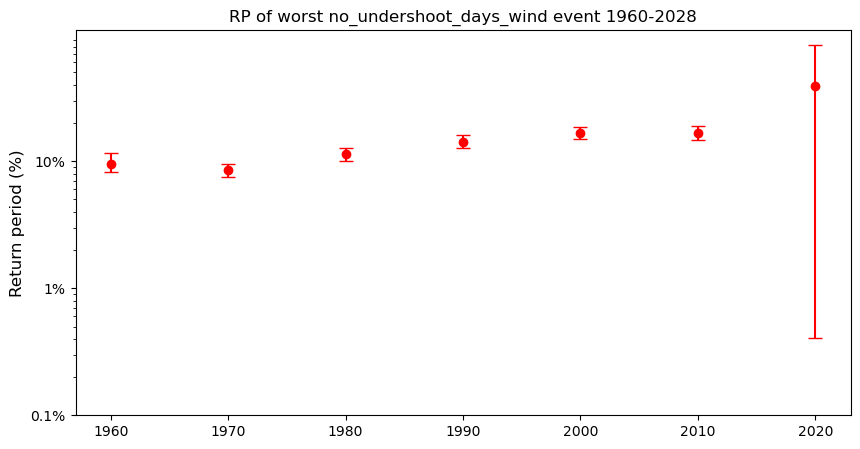

In [103]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(years)])
period_decade_025 = np.zeros([len(years)])
period_decade_975 = np.zeros([len(years)])

if worst_or_perc_rp == "worst":
    print("Calculating return period for worst (max) event")
    obs_bad_event = obs_df[obs_val_name].max()
elif worst_or_perc_rp == "perc":
    print(f"Calculating return period for {percentile}th percentile event")
    obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(years)):
    # Subset the params for the decade
    params_decade = params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_bad_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# if we are plotting the return period as a percentage
if plot_rp_percentage:
    y_val_mean = model_df_rl["mean_rp (%)"]
    y_val_025 = model_df_rl["025_rp (%)"]
    y_val_975 = model_df_rl["975_rp (%)"]
    y_label = "Return period (%)"

    # Set up the error bars
    # upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
    # lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])
    upper_errs = model_df_rl["975_rp (%)"] - model_df_rl["mean_rp (%)"]
    lower_errs = model_df_rl["mean_rp (%)"] - model_df_rl["025_rp (%)"]

    # set up the yticks
    yticks_ints = [0.001, 0.01, 0.1]
    yticks_strs = ["0.1%", "1%", "10%"]

else:
    y_val_mean = model_df_rl["mean_rp (years)"]
    y_val_025 = model_df_rl["025_rp (years)"]
    y_val_975 = model_df_rl["975_rp (years)"]
    y_label = "Return period (years)"

    # Set up the error bars
    upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
    lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

    # set up the yticks
    yticks_ints = [1, 10, 100, 1000]
    yticks_strs = ["1", "10", "100", "1000"]

# print the upper and lower errors
print(f"Upper errors: {upper_errs}")
print(f"Lower errors: {lower_errs}")

# assert that upper errs and lower errors are positive
assert np.all(upper_errs > 0), "Upper errors must be positive"
assert np.all(lower_errs > 0), "Lower errors must be positive"

# Plot the mean
plt.scatter(
    model_df_rl["decade"],
    y_val_mean,
    color="red",
)

# Plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    y_val_mean,
    yerr=[lower_errs, upper_errs],
    fmt="none",
    color="red",
    capsize=5,
)

# Set up the yscale
plt.yscale("log")

# Set up the yticks
plt.yticks(yticks_ints, yticks_strs)

# Set up the ylabel
plt.ylabel(y_label, fontsize=12)

# Set up the title
if worst_or_perc_rp == "worst":
    plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
elif worst_or_perc_rp == "perc":
    plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
else:
    raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# Set up the fname
fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# Set up the savepath
savepath = os.path.join(save_dir, fname)

# if the savepath does not exist
if not os.path.exists(savepath):
    print(f"Saving plot to {savepath}")

    # Save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)
else:
    print(f"Savepath {savepath} already exists")

Now move onto looking at the drivers.

In [105]:
exceedance_days = [20, 30, 40]
model_df = df_model_exceedance
model_val_name = "no_exceedance_days_demand_net_wind"

In [108]:
# First subset the data to specific thresholds
# Set up a dictionary for the exceedance
exceed_dict = {}

# Loop over the exceedance days
for exceed_day in exceedance_days:
    # print the threshold
    print(f"Threshold: {exceed_day}")

    # Filter the model df to be only the 
    # days greater than the threshold
    model_df_exceedance = model_df[model_df[model_val_name] > exceed_day]

    # # print the head of the model df
    # print(model_df_exceedance.head())

    # # print the shape of the model df
    # print(model_df_exceedance.shape)

    # extract a list of len three tuples
    # containing the init year, member and winter year
    exceedance_list = list(zip(model_df_exceedance["init_year"], model_df_exceedance["winter_year"], model_df_exceedance["member"]))

    # # # print the first 5 elements of the list
    # print(exceedance_list[:5])

    # # print the len of the list
    # print(len(exceedance_list))

    # Append the threshold to the dictionary
    exceed_dict[exceed_day] = exceedance_list

Threshold: 20
Threshold: 30
Threshold: 40


In [113]:
nboot = 1000
obs_variable = "msl"
model = "HadGEM3-GC31-MM"
psl_variable = "psl"
freq = "Amon"
experiment = "dcppA-hindcast"
calc_anoms = False
months = [10, 11, 12, 1, 2, 3]
climatology_period = [1990, 2018]
lat_bounds = [30, 80]
lon_bounds = [-90, 30]
files_loc_path = "/home/users/benhutch/unseen_multi_year/paths/paths_20240117T122513.csv"
save_prefix = "composite_obs_model"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots/unseen"
regrid_file = "/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc"

In [124]:
import glob

# Load the files location
files_loc = pd.read_csv(files_loc_path)

# print the data we seek
print(f"model: {model}")
print(f"experiment: {experiment}")
print(f"freq: {freq}")
print(f"psl_variable: {psl_variable}")

# Extract the path for the given model, experiment, freq, and variable
model_path_psl = files_loc.loc[
    (files_loc["model"] == model)
    & (files_loc["experiment"] == experiment)
    & (files_loc["frequency"] == freq)
    & (files_loc["variable"] == psl_variable)
]["path"].values[0]

# asser that the model path psl exists
assert os.path.exists(model_path_psl), "The model path psl does not exist"

# extract the model path root
model_path_root_psl = model_path_psl.split("/")[1]

# Set up an empty list of files
files_list = []

files_list_exceed = {}

# Loop over the exceedance days
for thresh in exceed_dict:
    # print the threshold
    print(f"Threshold: {thresh}")

    # Set up an empty list for the files for this threshold
    files_list = []

    # Loop over the exceedance list
    for i, (init_year, winter_year, member) in enumerate(exceed_dict[thresh]):
        # print the init year, winter year and member
        print(f"Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        if model_path_root_psl == "work":
            raise NotImplementedError("work path not implemented yet")
        elif model_path_root_psl == "gws":
            # Create the path
            path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{init_year}-r{member}i*_*_{init_year}??-*.nc"

            # glob this path
            files = glob.glob(path)

            # assert that files has length 1
            assert len(files) == 1, f"files has length {len(files)}"

            # extract the file
            file = files[0]

            # assert that this file exists
            assert os.path.exists(file), f"{file} does not exist"

        elif model_path_root_psl == "badc":
            raise NotImplementedError("home path not implemented yet")
        else:
            raise ValueError(f"Unknown model path root {model_path_root_psl}")
        
        # append the file to the files list
        files_list.append(file)

    # assign the files list to the files_list_exceed dictionary for this threshold
    files_list_exceed[thresh] = files_list

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
freq: Amon
psl_variable: psl
Threshold: 20
Init year: 1960, Winter year: 8, Member: 1
Init year: 1960, Winter year: 10, Member: 1
Init year: 1960, Winter year: 1, Member: 2
Init year: 1960, Winter year: 2, Member: 2
Init year: 1960, Winter year: 8, Member: 2
Init year: 1960, Winter year: 6, Member: 4
Init year: 1960, Winter year: 3, Member: 5
Init year: 1960, Winter year: 3, Member: 7
Init year: 1960, Winter year: 10, Member: 7
Init year: 1960, Winter year: 7, Member: 8
Init year: 1960, Winter year: 1, Member: 9
Init year: 1960, Winter year: 5, Member: 10
Init year: 1961, Winter year: 2, Member: 1
Init year: 1961, Winter year: 10, Member: 1
Init year: 1961, Winter year: 5, Member: 2
Init year: 1961, Winter year: 7, Member: 4
Init year: 1961, Winter year: 8, Member: 4
Init year: 1961, Winter year: 9, Member: 6
Init year: 1961, Winter year: 4, Member: 10
Init year: 1961, Winter year: 6, Member: 10
Init year: 1962, Winter year: 5, Member: 

In [131]:
files_list_exceed[40]

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1981-r4i1_gn_198111-199203.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1_gn_199211-200303.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s2013-r2i1_gn_201311-202403.nc']

In [134]:
importlib.reload(sys.modules["functions"])
from functions import set_integer_time_axis

In [137]:
df_model_exceedance["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [210]:
def preprocess_leads(
    ds,
    winter_year,
    freq,
    idx,
):
    """
    Preprocess the leads of the model data
    """

    # format the lead as an int
    ds = set_integer_time_axis(
        xro=ds,
        frequency=freq,
    )

    # # print the leads in ds
    # print(ds.time)

    # Use the winter year to find the leads to extract
    # for ONDJFM
    leads_extract = np.arange(winter_year * 12, winter_year * 12 + 6, 1)

    # # print the leads extract
    # print(leads_extract)

    # # print the indexes of time
    # print(ds.time)

    # Extract the leads
    ds = ds.sel(time=leads_extract).mean("time")

    # Add a new coordinate 'number' with a unique value
    ds = ds.expand_dims({"number": [idx]})

    return ds

In [223]:
# Form the concatenated dataset for the exceedance days
# loop over the thresholds
for thresh in [20]:
    # extract the files list
    files_list = files_list_exceed[thresh]

    # extract the exceedance list
    exceed_list = exceed_dict[thresh]

    # print both
    print(files_list)
    print(exceed_list)

    ds_list = []

    # Loop over the files
    for idx, (file, (init_year, winter_year, member)) in tqdm(enumerate(zip(files_list, exceed_list))):
        # print the file, init year, winter year and member
        # print(f"File: {file}, Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        # Load the data
        ds = xr.open_mfdataset(
            file,
            preprocess=lambda ds: preprocess_leads(
                ds=ds,
                winter_year=winter_year,
                freq=freq,
                idx=idx,
            ),
        )

        # append the ds_extract to the list
        ds_list.append(ds[psl_variable])

    # Concatenate the list of datasets
    combined_ds = xr.concat(ds_list, dim="number")

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-

44it [05:29,  7.49s/it]


KeyboardInterrupt: 

In [212]:
# convert to a cube
cube_psl = combined_ds.to_iris()

# subset to teh correct grid
cube_psl = cube_psl.intersection(longitude=(-180, 180), latitude=(-90, 90))

# subset to the region of interest
cube_psl = cube_psl.intersection(
    longitude=(lon_bounds[0], lon_bounds[1]),
    latitude=(lat_bounds[0], lat_bounds[1]),
)

In [213]:
calc_anoms = True

In [214]:
# if calc anoms is true
if calc_anoms:

    # set up a save directory for the climatologies
    save_dir_clim = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_clim"

    # assert that this directory exists
    assert os.path.exists(save_dir_clim), "The save directory does not exist"

    # set up the fname
    fname = f"climatology_{model}_{experiment}_{freq}_{psl_variable}_{climatology_period[0]}-{climatology_period[1]}_{lat_bounds[0]}-{lat_bounds[1]}_{lon_bounds[0]}-{lon_bounds[1]}_{months[0]}-{months[-1]}.nc"

    # set up the full climatology path
    climatology_path = os.path.join(save_dir_clim, fname)

    # if the climatology path exists
    if os.path.exists(climatology_path):
        print("The climatology file exists")
        print("Loading the climatology file")

        # load the file using iris
        cube_clim = iris.load_cube(climatology_path)

    else:
        print("The climatology file does not exist")
        print("Calculating the climatology")

        # Set up a list for the full ds's
        clim_dss = []
        # Loop over the years
        for year in tqdm(range(climatology_period[0], climatology_period[1] + 1)):
            member_list = []
            for member in unique_members:
                start_time = time.time()

                path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{year}-r{member}i*_*_{year}??-*.nc"

                # glob this path
                glob_start = time.time()
                files = glob.glob(path)
                glob_end = time.time()

                # assert
                assert (
                    len(files) == 1
                ), f"files has length {len(files)} for year {year} and member {member} and path {path}"

                # open all of the files
                # open_start = time.time()
                member_ds = xr.open_mfdataset(
                    files[0],
                    combine="nested",
                    concat_dim="time",
                    preprocess=lambda ds: preprocess(
                        ds=ds,
                        year=year,
                        variable=psl_variable,
                        months=months,
                    ),
                    parallel=True,
                    engine="netcdf4",
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                ).squeeze()
                # open_end = time.time()

                # id init year == climatology_period[0]
                # and member == unique_members[0]
                # set_time_start = time.time()
                if year == climatology_period[0] and member == unique_members[0]:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                        first_month_attr=True,
                    )
                else:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                    )
                # set_time_end = time.time()

                # take the mean over the time axis
                # mean_start = time.time()
                member_ds = member_ds.mean(dim="time")
                # mean_end = time.time()

                # append the member_ds to the member_list
                member_list.append(member_ds)

                # end_time = time.time()

                # # Print timing information
                # print(f"Year: {year}, Member: {member}")
                # print(f"  Total time: {end_time - start_time:.2f} seconds")
                # print(f"  glob time: {glob_end - glob_start:.2f} seconds")
                # print(f"  open_mfdataset time: {open_end - open_start:.2f} seconds")
                # print(f"  set_integer_time_axis time: {set_time_end - set_time_start:.2f} seconds")
                # print(f"  mean time: {mean_end - mean_start:.2f} seconds")

            # Concatenate with a new member dimension using xarray
            member_ds = xr.concat(member_list, dim="member")
            # append the member_ds to the init_year_list
            clim_dss.append(member_ds)
        # Concatenate the init_year list along the init dimension
        # and rename as lead time
        ds = xr.concat(clim_dss, "init")

        # print ds
        print(ds)

        # set up the members
        ds["member"] = unique_members
        ds["init"] = np.arange(climatology_period[0], climatology_period[1] + 1)

        # extract the variable
        ds_var = ds[psl_variable]

        # # take the mean over lead dimension
        # ds_clim = ds_var.mean(dim="lead")

        # take the mean over member dimension
        ds_clim = ds_var.mean(dim="member")

        # take the mean over init dimension
        ds_clim = ds_clim.mean(dim="init")

        # convert to a cube
        cube_clim = ds_clim.to_iris()

        # # regrid the model data to the obs grid
        # cube_clim_regrid = cube_clim.regrid(cube_obs, iris.analysis.Linear())

        # subset to the correct grid
        cube_clim = cube_clim.intersection(
            longitude=(-180, 180), latitude=(-90, 90)
        )

        # subset to the region of interest
        cube_clim = cube_clim.intersection(
            latitude=(lat_bounds[0], lat_bounds[1]),
            longitude=(lon_bounds[0], lon_bounds[1]),
        )

        # if the climatology file does not exist
        print("Saving the climatology file")

        # save the cube_clim
        iris.save(cube_clim, climatology_path)

The climatology file exists
Loading the climatology file


In [215]:
cube_clim

<iris 'Cube' of psl / (unknown) (latitude: 90; longitude: 144)>

In [216]:
cube_psl

Psl (unknown),number,latitude,longitude
Shape,73,90,144
Dimension coordinates,,,
number,x,-,-
latitude,-,x,-
longitude,-,-,x


In [217]:
# take the mean of cube_psl over number and time
cube_psl_mean = cube_psl.collapsed(["number"], iris.analysis.MEAN)

In [218]:
# calculate the anomalies
field = (cube_psl_mean.data - cube_clim.data) / 100

In [219]:
lons = cube_psl.coord("longitude").points
lats = cube_psl.coord("latitude").points

In [220]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

In [221]:
importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

NameError: name 'title' is not defined

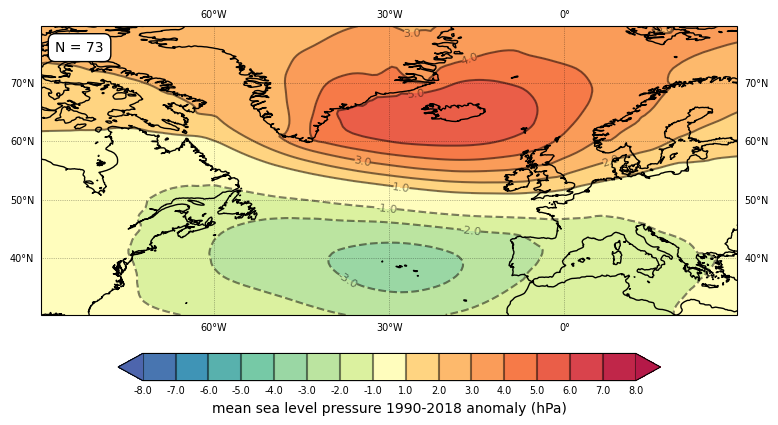

In [222]:
# set up the figure
fig, ax = plt.subplots(
    figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree())
)

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    clevs = np.array(np.arange(988, 1024 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"lons shape: {lons.shape}")
# print(f"lats shape: {lats.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    lons, lats, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
contours = ax.contour(
    lons,
    lats,
    field,
    clevs,
    colors="black",
    transform=ccrs.PlateCarree(),
    linewidth=0.2,
    alpha=0.5,
)
if calc_anoms:
    ax.clabel(
        contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0
    )
else:
    ax.clabel(
        contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0
    )

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# set up the num events
num_events = len(cube_psl.coord("number").points)

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()
